In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


here the objective is to fit the logit graph model to the brain graphs and then 
visualize the original vs fitted graphs

In [17]:
import sys
import os
sys.path.append('../')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [18]:
PATH = f'../data/connectomes/brain_graph/'

DATASETS = ['repeated_10_scale_33',
            'repeated_10_scale_60',
            'repeated_10_scale_125',
            'repeated_10_scale_250'
            ]

files = []
for DATASET in DATASETS:
    # sort 10 graphs for each dataset
    for file in sorted(os.listdir(PATH+DATASET))[:10]:
        if file.endswith('.graphml'):
            files.append(os.path.join(PATH+DATASET, file))

print(files[:4])


['../data/connectomes/brain_graph/repeated_10_scale_33/100206_repeated10_scale33.graphml', '../data/connectomes/brain_graph/repeated_10_scale_33/100307_repeated10_scale33.graphml', '../data/connectomes/brain_graph/repeated_10_scale_33/100408_repeated10_scale33.graphml', '../data/connectomes/brain_graph/repeated_10_scale_33/100610_repeated10_scale33.graphml']


In [19]:

def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL', edge_delta=None, min_gic_threshold=None, verbose=True):
   """
   Estimates parameters, generates a graph using the Logit Graph model,
   and calculates GIC, allowing for different convergence criteria.

   Args:
       real_graph (nx.Graph or np.ndarray): The target graph.
       d (int): Parameter for the Logit model (number of neighbors).
       n_iteration (int): Maximum number of iterations for graph generation.
       warm_up (int): Number of initial iterations to discard.
       patience (int): Number of iterations to wait for improvement before stopping.
       dist_type (str): Distance type for GIC ('KL', 'L1', 'L2').
       convergence_criteria (str): Criterion for stopping ('spectrum' or 'spectrum_and_edges').

   Returns:
       tuple: Contains the best generated graph, sigma, GIC values,
              spectrum differences, edge differences, best iteration index, and all graphs.
   """
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)

   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   # Using default L1 regularization as before, adjust if needed
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up,
      "patience": patience,
      "edge_delta": edge_delta,
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)

   print(f"Running generation with convergence criterion: {edge_delta}")
   
   graphs, spec, spectrum_diffs, best_iteration, best_graph_arr = graph_model.populate_edges_spectrum_min_gic(
        max_iterations=n_iteration,
        # warm_up=warm_up,
        patience=patience,
        real_graph=real_graph,
        edge_delta=edge_delta,
        min_gic_threshold=min_gic_threshold,
        gic_dist_type=dist_type,
        verbose=verbose,
    )


   print(f"Finish generation with convergence criterion: {edge_delta}")
   # Calculate edge differences
   real_edges = np.sum(real_graph) / 2
   edge_diffs = [abs(np.sum(g) / 2 - real_edges) for g in graphs]

   # Use the best graph found based on the selected criteria/iteration
   # best_graph = graphs[best_iteration]

   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph_arr)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type
   ).calculate_gic()

   return best_graph_arr, sigma, [gic_value], spectrum_diffs, edge_diffs, best_iteration, graphs



# single model LG fitting

Here we fit and visualize the logit graph model to the brain graphs

In [9]:
def visualize_original_vs_fitted_graphs(results, figsize=(20, 12), node_size=30, font_size=8, edge_width=0.5, graphs_per_plot=10):
    """
    Visualize original graphs vs fitted LG graphs with GIC values.
    Creates multiple plots with up to graphs_per_plot graphs each.
    
    Parameters:
    -----------
    results : dict
        Results from fit_logit_graphs_to_dataset
    figsize : tuple
        Figure size
    node_size : int
        Size of nodes
    font_size : int
        Font size for labels
    edge_width : float
        Width of edges
    graphs_per_plot : int
        Number of graphs to display per plot
    
    Returns:
    --------
    figs : list
        List of matplotlib.figure.Figure objects
    """
    n_graphs = len(results['original_graphs'])
    
    # Calculate number of plots needed
    n_plots = (n_graphs + graphs_per_plot - 1) // graphs_per_plot
    
    figs = []
    
    # Color schemes
    original_node_color = '#4472C4'  # Blue for original
    fitted_node_color = '#E74C3C'    # Red for fitted
    edge_color = '#8B8B8B'           # Gray for edges
    
    for plot_idx in range(n_plots):
        start_idx = plot_idx * graphs_per_plot
        end_idx = min(start_idx + graphs_per_plot, n_graphs)
        current_n_graphs = end_idx - start_idx
        
        # Create subplot grid: 2 rows (original vs fitted), current_n_graphs columns
        fig, axes = plt.subplots(2, current_n_graphs, figsize=figsize)
        
        # Handle single graph case
        if current_n_graphs == 1:
            axes = axes.reshape(2, 1)
        
        for i in range(current_n_graphs):
            graph_idx = start_idx + i
            original_graph = results['original_graphs'][graph_idx]
            fitted_graph = results['fitted_graphs'][graph_idx]
            gic_value = results['gic_values'][graph_idx]
            stats = results['graph_stats'][graph_idx]
            
            # Plot original graph (top row)
            ax_orig = axes[0, i] if current_n_graphs > 1 else axes[0]
            pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig,
                                  node_color=original_node_color, node_size=node_size, alpha=0.8)
            
            ax_orig.set_title(f'Original Graph {graph_idx+1}\n({stats["original_nodes"]} nodes, {stats["original_edges"]} edges)',
                             fontsize=font_size+2, fontweight='bold', pad=10)
            ax_orig.axis('off')
            
            # Plot fitted graph (bottom row)
            ax_fitted = axes[1, i] if current_n_graphs > 1 else axes[1]
            
            if fitted_graph is not None and results['fit_success'][graph_idx]:
                pos_fitted = nx.spring_layout(fitted_graph, k=1, iterations=50, seed=42)
                
                nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted,
                                      edge_color=edge_color, width=edge_width, alpha=0.6)
                nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted,
                                      node_color=fitted_node_color, node_size=node_size, alpha=0.8)
                
                title = f'Fitted LG Graph {graph_idx+1}\n({stats["fitted_nodes"]} nodes, {stats["fitted_edges"]} edges)\nGIC: {gic_value:.4f}'
            else:
                title = f'Fitted LG Graph {graph_idx+1}\n(Fitting Failed)'
            
            ax_fitted.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
            ax_fitted.axis('off')
        
        # Add overall title for this plot
        fig.suptitle(f'Original Brain Connectomes vs Fitted Logit Graph Models (Graphs {start_idx+1}-{end_idx})', 
                    fontsize=16, fontweight='bold', y=0.95)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.92])
        figs.append(fig)
    
    return figs


In [10]:
def fit_logit_graphs_to_dataset(graphs, n_graphs=5, sim_params=None):
    """
    Fit logit graph models to the first n graphs in the dataset.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n_graphs : int
        Number of graphs to process
    sim_params : dict
        Simulation parameters for logit graph fitting
    
    Returns:
    --------
    results : dict
        Dictionary containing original graphs, fitted graphs, and GIC values
    """
    if sim_params is None:
        sim_params = {
            "d": 0,
            "n_iteration": 10000,  # Reduced for faster computation
            "warm_up": 500,
            "patience": 2000,
            "dist_type": 'KL',
            "min_gic_threshold": 5,
            "verbose": True,
        }
    
    results = {
        'original_graphs': [],
        'fitted_graphs': [],
        'gic_values': [],
        'fit_success': [],
        'graph_stats': []
    }
    
    n_graphs = min(n_graphs, len(graphs))
    
    for i in range(n_graphs):
        print(f"\n{'='*20} Processing Graph {i+1}/{n_graphs} {'='*20}")
        
        original_graph = graphs[i]
        adj_matrix = nx.to_numpy_array(original_graph)
        n_nodes = original_graph.number_of_nodes()
        n_edges = original_graph.number_of_edges()
        
        print(f"Original graph - Nodes: {n_nodes}, Edges: {n_edges}")
        
        try:
            # Fit logit graph model
            logit_results = get_logit_graph(
                real_graph=adj_matrix.copy(),
                d=sim_params["d"],
                n_iteration=sim_params["n_iteration"],
                warm_up=sim_params["warm_up"],
                patience=sim_params["patience"],
                dist_type=sim_params["dist_type"],
                edge_delta=None,  # Use spectrum convergence only
                min_gic_threshold=sim_params["min_gic_threshold"],
                verbose=sim_params["verbose"],
            )
            
            fitted_adj_matrix = logit_results[0]
            fitted_graph = nx.from_numpy_array(fitted_adj_matrix)
            gic_value = logit_results[2][0]
            best_iteration = logit_results[5]
            
            results['original_graphs'].append(original_graph)
            results['fitted_graphs'].append(fitted_graph)
            results['gic_values'].append(gic_value)
            results['fit_success'].append(True)
            results['graph_stats'].append({
                'original_nodes': n_nodes,
                'original_edges': n_edges,
                'fitted_nodes': fitted_graph.number_of_nodes(),
                'fitted_edges': fitted_graph.number_of_edges(),
                'best_iteration': best_iteration
            })
            
            print(f"Fitting successful - GIC: {gic_value:.4f}, Best iteration: {best_iteration}")
            print(f"Fitted graph - Nodes: {fitted_graph.number_of_nodes()}, Edges: {fitted_graph.number_of_edges()}")
            
        except Exception as e:
            print(f"Error fitting graph {i+1}: {e}")
            results['original_graphs'].append(original_graph)
            results['fitted_graphs'].append(None)
            results['gic_values'].append(np.nan)
            results['fit_success'].append(False)
            results['graph_stats'].append({
                'original_nodes': n_nodes,
                'original_edges': n_edges,
                'fitted_nodes': 0,
                'fitted_edges': 0,
                'best_iteration': 0
            })
        
        gc.collect()  # Clean up memory
    
    return results


In [11]:
def print_fitting_summary(results):
    """Print summary of fitting results and return a dataframe."""
    import pandas as pd
    
    n_graphs = len(results['original_graphs'])
    successful_fits = sum(results['fit_success'])
    
    print(f"\n{'='*50}")
    print(f"LOGIT GRAPH FITTING SUMMARY")
    print(f"{'='*50}")
    print(f"Total graphs processed: {n_graphs}")
    print(f"Successful fits: {successful_fits}/{n_graphs}")
    print(f"Success rate: {successful_fits/n_graphs*100:.1f}%")
    
    if successful_fits > 0:
        valid_gics = [gic for gic, success in zip(results['gic_values'], results['fit_success']) 
                     if success and not np.isnan(gic)]
        if valid_gics:
            print(f"\nGIC Statistics:")
            print(f"  Mean GIC: {np.mean(valid_gics):.4f}")
            print(f"  Std GIC: {np.std(valid_gics):.4f}")
            print(f"  Min GIC: {np.min(valid_gics):.4f}")
            print(f"  Max GIC: {np.max(valid_gics):.4f}")
    
    print(f"\nDetailed Results:")
    
    # Create dataframe with detailed results
    df_data = []
    for i, (gic, success, stats) in enumerate(zip(results['gic_values'], results['fit_success'], results['graph_stats'])):
        status = "SUCCESS" if success else "FAILED"
        gic_value = gic if success and not np.isnan(gic) else np.nan
        
        print(f"  Graph {i+1}: {status} | GIC: {gic_value if not np.isnan(gic_value) else 'N/A'} | "
              f"Orig: {stats['original_nodes']}n/{stats['original_edges']}e | "
              f"Fitted: {stats['fitted_nodes']}n/{stats['fitted_edges']}e")
        
        df_data.append({
            'graph_id': i+1,
            'status': status,
            'fit_success': success,
            'gic_value': gic_value,
            'original_nodes': stats['original_nodes'],
            'original_edges': stats['original_edges'],
            'fitted_nodes': stats['fitted_nodes'],
            'fitted_edges': stats['fitted_edges'],
            'best_iteration': stats['best_iteration']
        })
    
    df = pd.DataFrame(df_data)
    return df


In [12]:
# Define simulation parameters for faster computation on multiple graphs
sim_params = {
    "d": 0,
    "n_iteration": 8000,   # Reduced for faster computation
    "warm_up": 500,
    "patience": 1500,      # Reduced patience
    "dist_type": 'KL',
    "min_gic_threshold": 5,
    "verbose": True,
}

# Fit logit graphs to the first 5 graphs
print("Starting logit graph fitting experiment...")
fitting_results = fit_logit_graphs_to_dataset(graphs, n_graphs=30, sim_params=sim_params)

Starting logit graph fitting experiment...

==================== Processing Graph 1/30 ====================
Original graph - Nodes: 129, Edges: 1378
Running generation with convergence criterion: None
iteration: 0
	 Current GIC (KL): inf (Threshold: 5)
	 Best Spectrum Diff: inf
	 Patience: 0/1500
	 Current edges: 0.0 (Real edges: 1378.0)


KeyboardInterrupt: 

In [30]:
import pickle
import os
os.makedirs(f'runs/fitting_results_braingraph_{DATASET}', exist_ok=True)
with open(f'runs/fitting_results_braingraph_{DATASET}/fitting_results.pkl', 'wb') as f:
    pickle.dump(fitting_results, f)


In [ ]:
# Print summary of results
df_results = print_fitting_summary(fitting_results)
df_results.to_csv(f'runs/fitting_results_braingraph_{DATASET}/fitting_results.csv', index=False)

In [ ]:
display(df_results.head()), df_results['gic_value'].describe()

In [ ]:
# Create the comparison visualization
fig_comparison = visualize_original_vs_fitted_graphs(
    fitting_results, 
    figsize=(23, 12), 
    node_size=30, 
    font_size=8, 
    edge_width=0.5
)

In [46]:
import os
os.makedirs(f'../images/fitting_results_braingraph_{DATASET}', exist_ok=True)
with open(f'../images/fitting_results_braingraph_{DATASET}/original_vs_fitted_lg_graphs.pkl', 'wb') as f:
    pickle.dump(fig_comparison, f)

# Comparision LG with other models

here we compare the logit graph model with other models

In [20]:
def create_summary_dataframe(graph_results):
    """Create a summary DataFrame from the results."""
    df_data = []
    
    for graph_result in graph_results:
        graph_id = graph_result['graph_id']
        original_nodes = graph_result['original_nodes']
        original_edges = graph_result['original_edges']
        
        for model_name, model_data in graph_result['models'].items():
            df_data.append({
                'graph_id': graph_id,
                'model': model_name,
                'gic_value': model_data['gic_value'],
                'param': model_data['param'],
                'fit_success': model_data['fit_success'],
                'original_nodes': original_nodes,
                'original_edges': original_edges,
                'fitted_nodes': model_data['fitted_nodes'],
                'fitted_edges': model_data['fitted_edges'],
                'best_iteration': model_data['best_iteration']
            })
    
    return pd.DataFrame(df_data)


In [21]:
def clean_and_convert(param):
    """Clean and convert parameter string to float."""
    cleaned_param = ''.join(c for c in str(param) if c.isdigit() or c == '.' or c == '-')
    try:
        return float(cleaned_param)
    except:
        return np.nan


def fit_multiple_models_to_dataset(graphs, n_graphs=5, sim_params=None):
    """
    Fit LG and other random graph models to the first n graphs in the dataset.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n_graphs : int
        Number of graphs to process
    sim_params : dict
        Simulation parameters for logit graph fitting
    
    Returns:
    --------
    results : dict
        Dictionary containing all results for each graph and model, including fitted_graphs dict
    """
    results = {
        'graph_results': [],  # List of results for each graph
        'summary_df': None,
        'fitted_graphs': {}  # Dict with graph names as keys and fitted graphs as values
    }
    
    n_graphs = min(n_graphs, len(graphs))
    
    for i in range(n_graphs):
        print(f"\n{'='*30} Processing Graph {i+1}/{n_graphs} {'='*30}")
        
        original_graph = graphs[i]
        adj_matrix = nx.to_numpy_array(original_graph)
        n_nodes = original_graph.number_of_nodes()
        n_edges = original_graph.number_of_edges()
        
        print(f"Original graph - Nodes: {n_nodes}, Edges: {n_edges}")
        
        graph_result = {
            'graph_id': i+1,
            'original_graph': original_graph,
            'original_nodes': n_nodes,
            'original_edges': n_edges,
            'models': {}
        }
        
        # 1. Fit Logit Graph (LG) model
        best_logit_results = None
        best_gic = np.inf
        for d in sim_params["d_list"]:
            print(f"\n--- Fitting Logit Graph (LG) for d={d}---")
            logit_results = get_logit_graph(
                real_graph=adj_matrix.copy(),
                d=d,
                n_iteration=sim_params["n_iteration"],
                warm_up=sim_params["warm_up"],
                patience=sim_params["patience"],
                dist_type=sim_params["dist_type"],
                edge_delta=sim_params["edge_delta"],
                min_gic_threshold=sim_params["min_gic_threshold"],
                verbose=sim_params["verbose"]
            )
            if logit_results[2][0] < best_gic:
                best_gic = logit_results[2][0]
                best_logit_results = logit_results
        
        fitted_adj_matrix = best_logit_results[0]
        fitted_graph = nx.from_numpy_array(fitted_adj_matrix)
        gic_value = best_logit_results[2][0]
        sigma = best_logit_results[1]
        best_iteration = best_logit_results[4]
        
        graph_result['models']['LG'] = {
            'fitted_graph': fitted_graph,
            'gic_value': gic_value,
            'param': sigma,
            'fit_success': True,
            'fitted_nodes': fitted_graph.number_of_nodes(),
            'fitted_edges': fitted_graph.number_of_edges(),
            'best_iteration': best_iteration
        }
        
        # Add to fitted_graphs dict
        results['fitted_graphs'][f'graph_{i+1}_LG'] = fitted_graph
        
        print(f"LG fitting successful - GIC: {gic_value:.4f}, Sigma: {sigma:.4f}")
            
        # 2. Fit other random graph models
        print("\n--- Fitting Other Random Graph Models ---")
        
        # Create model selector
        selector = ms.GraphModelSelection(
            graph=original_graph,
            log_graphs=[fitted_graph] if graph_result['models']['LG']['fit_success'] else [original_graph],
            log_params=[graph_result['models']['LG']['param']] if graph_result['models']['LG']['fit_success'] else [1.0],
            models=["ER", "WS", "GRG", "BA"],
            n_runs=5,
            parameters=[{'lo': 0.01, 'hi': 1},  # ER
                        {'k': {'lo': 2, 'hi': 20, 'step': 2}, 'p': {'lo': 0.01, 'hi': 1}},  # WS
                        {'lo': 1, 'hi': 3},     # GRG
                        {'lo': 1, 'hi': 5},     # BA
            ]
        )
        
        model_results = selector.select_model_avg_spectrum()
        
        for estimate in model_results['estimates']:
            model_name = estimate['model']
            if model_name != 'LG':  # LG already processed
                param = clean_and_convert(estimate['param'])
                gic_value = estimate['GIC']
                
                # Generate the fitted graph
                func = selector.model_function(model_name=model_name)
                fitted_graph = func(n_nodes, param)
                
                graph_result['models'][model_name] = {
                    'fitted_graph': fitted_graph,
                    'gic_value': gic_value,
                    'param': param,
                    'fit_success': True,
                    'fitted_nodes': fitted_graph.number_of_nodes(),
                    'fitted_edges': fitted_graph.number_of_edges(),
                    'best_iteration': None
                }
                
                # Add to fitted_graphs dict
                results['fitted_graphs'][f'graph_{i+1}_{model_name}'] = fitted_graph
                
                print(f"{model_name} fitting - GIC: {gic_value:.4f}, Param: {param:.4f}")
                
        
        results['graph_results'].append(graph_result)
        gc.collect()  # Clean up memory
    
    # Create summary DataFrame
    results['summary_df'] = create_summary_dataframe(results['graph_results'])
    
    return results


In [22]:

def visualize_model_comparison(results, figsize=(25, 15), node_size=30, font_size=8, edge_width=0.5):
    """
    Visualize original graphs vs LG vs best fitting model for each graph.
    
    Parameters:
    -----------
    results : dict
        Results from fit_multiple_models_to_dataset
    figsize : tuple
        Figure size
    node_size : int
        Size of nodes
    font_size : int
        Font size for labels
    edge_width : float
        Width of edges
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    graph_results = results['graph_results']
    n_graphs = len(graph_results)
    
    # Create subplot grid: 3 rows (original, LG, best model), n_graphs columns
    fig, axes = plt.subplots(3, n_graphs, figsize=figsize)
    
    # Handle single graph case
    if n_graphs == 1:
        axes = axes.reshape(3, 1)
    
    # Color schemes
    original_color = '#4472C4'    # Blue for original
    lg_color = '#E74C3C'          # Red for LG
    best_color = '#2ECC71'        # Green for best model
    edge_color = '#8B8B8B'        # Gray for edges
    
    for i, graph_result in enumerate(graph_results):
        original_graph = graph_result['original_graph']
        lg_data = graph_result['models']['LG']
        
        # Find best model (lowest GIC)
        valid_models = {name: data for name, data in graph_result['models'].items() 
                       if data['fit_success'] and not np.isinf(data['gic_value'])}
        
        if valid_models:
            best_model_name = min(valid_models.keys(), key=lambda k: valid_models[k]['gic_value'])
            best_model_data = valid_models[best_model_name]
        else:
            best_model_name = "None"
            best_model_data = None
        
        # Plot original graph (top row)
        ax_orig = axes[0, i]
        pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
        
        nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig,
                              edge_color=edge_color, width=edge_width, alpha=0.6)
        nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig,
                              node_color=original_color, node_size=node_size, alpha=0.8)
        
        ax_orig.set_title(f'Original Graph {i+1}\n({graph_result["original_nodes"]} nodes, {graph_result["original_edges"]} edges)',
                         fontsize=font_size+2, fontweight='bold', pad=10)
        ax_orig.axis('off')
        
        # Plot LG fitted graph (middle row)
        ax_lg = axes[1, i]
        
        if lg_data['fitted_graph'] is not None and lg_data['fit_success']:
            pos_lg = nx.spring_layout(lg_data['fitted_graph'], k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(lg_data['fitted_graph'], pos_lg, ax=ax_lg,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(lg_data['fitted_graph'], pos_lg, ax=ax_lg,
                                  node_color=lg_color, node_size=node_size, alpha=0.8)
            
            title = f'LG Model\n({lg_data["fitted_nodes"]} nodes, {lg_data["fitted_edges"]} edges)\nGIC: {lg_data["gic_value"]:.4f}'
        else:
            title = f'LG Model\n(Fitting Failed)'
        
        ax_lg.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
        ax_lg.axis('off')
        
        # Plot best model (bottom row)
        ax_best = axes[2, i]
        
        if best_model_data is not None and best_model_data['fitted_graph'] is not None:
            pos_best = nx.spring_layout(best_model_data['fitted_graph'], k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(best_model_data['fitted_graph'], pos_best, ax=ax_best,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(best_model_data['fitted_graph'], pos_best, ax=ax_best,
                                  node_color=best_color, node_size=node_size, alpha=0.8)
            
            title = f'Best Model: {best_model_name}\n({best_model_data["fitted_nodes"]} nodes, {best_model_data["fitted_edges"]} edges)\nGIC: {best_model_data["gic_value"]:.4f}'
        else:
            title = f'Best Model: {best_model_name}\n(No valid fits)'
        
        ax_best.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
        ax_best.axis('off')
    
    # Add overall title
    fig.suptitle('Brain Connectomes: Original vs LG vs Best Random Graph Model', 
                fontsize=18, fontweight='bold', y=0.95)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    return fig

def calculate_graph_attributes(graph):
    """
    Calculate various graph attributes for a given graph.
    
    Parameters:
    -----------
    graph : networkx.Graph
        The graph to analyze
    
    Returns:
    --------
    dict : Dictionary containing graph attributes
    """
    if graph is None or graph.number_of_nodes() == 0:
        return {
            'degree_centrality_mean': np.nan,
            'degree_centrality_std': np.nan,
            'betweenness_centrality_mean': np.nan,
            'betweenness_centrality_std': np.nan,
            'closeness_centrality_mean': np.nan,
            'closeness_centrality_std': np.nan,
            'eigenvector_centrality_mean': np.nan,
            'eigenvector_centrality_std': np.nan,
            'clustering_coefficient_mean': np.nan,
            'clustering_coefficient_std': np.nan,
            'average_path_length': np.nan,
            'diameter': np.nan,
            'density': np.nan,
            'transitivity': np.nan,
            'assortativity': np.nan,
            'number_of_components': np.nan,
            'largest_component_size': np.nan
        }
    
    try:
        # Basic properties
        density = nx.density(graph)
        transitivity = nx.transitivity(graph)
        
        # Centrality measures
        degree_centrality = nx.degree_centrality(graph)
        betweenness_centrality = nx.betweenness_centrality(graph)
        closeness_centrality = nx.closeness_centrality(graph)
        
        # Eigenvector centrality (handle disconnected graphs)
        try:
            eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
        except:
            eigenvector_centrality = {node: 0 for node in graph.nodes()}
        
        # Clustering coefficient
        clustering_coefficient = nx.clustering(graph)
        
        # Path-based measures (only for connected graphs)
        if nx.is_connected(graph):
            average_path_length = nx.average_shortest_path_length(graph)
            diameter = nx.diameter(graph)
        else:
            # For disconnected graphs, calculate on largest component
            largest_cc = max(nx.connected_components(graph), key=len)
            largest_subgraph = graph.subgraph(largest_cc)
            if len(largest_cc) > 1:
                average_path_length = nx.average_shortest_path_length(largest_subgraph)
                diameter = nx.diameter(largest_subgraph)
            else:
                average_path_length = 0
                diameter = 0
        
        # Assortativity
        try:
            assortativity = nx.degree_assortativity_coefficient(graph)
        except:
            assortativity = np.nan
        
        # Component analysis
        components = list(nx.connected_components(graph))
        number_of_components = len(components)
        largest_component_size = len(max(components, key=len)) if components else 0
        
        return {
            'degree_centrality_mean': np.mean(list(degree_centrality.values())),
            'degree_centrality_std': np.std(list(degree_centrality.values())),
            'betweenness_centrality_mean': np.mean(list(betweenness_centrality.values())),
            'betweenness_centrality_std': np.std(list(betweenness_centrality.values())),
            'closeness_centrality_mean': np.mean(list(closeness_centrality.values())),
            'closeness_centrality_std': np.std(list(closeness_centrality.values())),
            'eigenvector_centrality_mean': np.mean(list(eigenvector_centrality.values())),
            'eigenvector_centrality_std': np.std(list(eigenvector_centrality.values())),
            'clustering_coefficient_mean': np.mean(list(clustering_coefficient.values())),
            'clustering_coefficient_std': np.std(list(clustering_coefficient.values())),
            'average_path_length': average_path_length,
            'diameter': diameter,
            'density': density,
            'transitivity': transitivity,
            'assortativity': assortativity,
            'number_of_components': number_of_components,
            'largest_component_size': largest_component_size
        }
    
    except Exception as e:
        print(f"Error calculating graph attributes: {e}")
        return {
            'degree_centrality_mean': np.nan,
            'degree_centrality_std': np.nan,
            'betweenness_centrality_mean': np.nan,
            'betweenness_centrality_std': np.nan,
            'closeness_centrality_mean': np.nan,
            'closeness_centrality_std': np.nan,
            'eigenvector_centrality_mean': np.nan,
            'eigenvector_centrality_std': np.nan,
            'clustering_coefficient_mean': np.nan,
            'clustering_coefficient_std': np.nan,
            'average_path_length': np.nan,
            'diameter': np.nan,
            'density': np.nan,
            'transitivity': np.nan,
            'assortativity': np.nan,
            'number_of_components': np.nan,
            'largest_component_size': np.nan
        }

def analyze_fitted_graphs_attributes(results):
    """
    Calculate graph attributes for all fitted graphs in the results.
    
    Parameters:
    -----------
    results : dict
        Results from fit_multiple_models_to_dataset
    
    Returns:
    --------
    dict : Dictionary containing graph attributes for all graphs
    """
    graph_attributes = {}
    
    print("Calculating graph attributes for fitted graphs...")
    
    # Analyze original graphs
    for graph_result in results['graph_results']:
        graph_id = graph_result['graph_id']
        original_graph = graph_result['original_graph']
        
        print(f"Analyzing original graph {graph_id}...")
        graph_attributes[f'graph_{graph_id}_original'] = calculate_graph_attributes(original_graph)
        
        # Analyze fitted models
        for model_name, model_data in graph_result['models'].items():
            if model_data['fit_success'] and model_data['fitted_graph'] is not None:
                print(f"Analyzing {model_name} model for graph {graph_id}...")
                graph_attributes[f'graph_{graph_id}_{model_name}'] = calculate_graph_attributes(model_data['fitted_graph'])
    
    return graph_attributes

def create_attributes_comparison_dataframe(results, graph_attributes):
    """
    Create a DataFrame comparing graph attributes across models.
    
    Parameters:
    -----------
    results : dict
        Results from fit_multiple_models_to_dataset
    graph_attributes : dict
        Graph attributes from analyze_fitted_graphs_attributes
    
    Returns:
    --------
    pandas.DataFrame : DataFrame with graph attributes comparison
    """
    rows = []
    
    for graph_result in results['graph_results']:
        graph_id = graph_result['graph_id']
        
        # Add original graph
        orig_attrs = graph_attributes.get(f'graph_{graph_id}_original', {})
        row = {
            'graph_id': graph_id,
            'model': 'Original',
            'gic_value': np.nan,
            'fit_success': True,
            **orig_attrs
        }
        rows.append(row)
        
        # Add fitted models
        for model_name, model_data in graph_result['models'].items():
            attrs = graph_attributes.get(f'graph_{graph_id}_{model_name}', {})
            row = {
                'graph_id': graph_id,
                'model': model_name,
                'gic_value': model_data['gic_value'] if model_data['fit_success'] else np.nan,
                'fit_success': model_data['fit_success'],
                **attrs
            }
            rows.append(row)
    
    return pd.DataFrame(rows)

def print_model_comparison_summary(results):
    """Print summary of model comparison results."""
    df = results['summary_df']
    graph_results = results['graph_results']
    
    print(f"\n{'='*60}")
    print(f"MODEL COMPARISON SUMMARY")
    print(f"{'='*60}")
    print(f"Total graphs processed: {len(graph_results)}")
    
    # Success rates by model
    print(f"\nSuccess Rates by Model:")
    for model in df['model'].unique():
        model_df = df[df['model'] == model]
        success_rate = model_df['fit_success'].mean() * 100
        print(f"  {model}: {success_rate:.1f}%")
    
    # GIC statistics by model
    print(f"\nGIC Statistics by Model:")
    for model in df['model'].unique():
        model_df = df[(df['model'] == model) & (df['fit_success'] == True)]
        if len(model_df) > 0:
            valid_gics = model_df[model_df['gic_value'] != np.inf]['gic_value']
            if len(valid_gics) > 0:
                print(f"  {model}: Mean={valid_gics.mean():.4f}, Std={valid_gics.std():.4f}, Min={valid_gics.min():.4f}, Max={valid_gics.max():.4f}")
            else:
                print(f"  {model}: No valid GIC values")
        else:
            print(f"  {model}: No successful fits")
    
    # Best model for each graph
    print(f"\nBest Model for Each Graph (by GIC):")
    for graph_result in graph_results:
        graph_id = graph_result['graph_id']
        valid_models = {name: data for name, data in graph_result['models'].items() 
                       if data['fit_success'] and not np.isinf(data['gic_value'])}
        
        if valid_models:
            best_model = min(valid_models.keys(), key=lambda k: valid_models[k]['gic_value'])
            best_gic = valid_models[best_model]['gic_value']
            print(f"  Graph {graph_id}: {best_model} (GIC: {best_gic:.4f})")
        else:
            print(f"  Graph {graph_id}: No valid fits")



In [ ]:
#
# Define simulation parameters
#

sim_params = {
    "d_list": [0, 1, 2],
    "n_iteration": 10_000,
    "warm_up": 200,
    "edge_delta": 30,
    "patience": 1000,
    "dist_type": 'KL',
    "min_gic_threshold": 1,
    "verbose": True,
}

batch_size = 20

folder = 'runs/fitting_results_braingraph_multiple_datasets'
os.makedirs(folder, exist_ok=True)

print("Starting expanded model comparison experiment...")
for i in range(0, len(files), batch_size):
    graphs = [nx.read_graphml(file) for file in files[i:i+batch_size]]
    model_results = fit_multiple_models_to_dataset(graphs, n_graphs=batch_size, sim_params=sim_params)
    graph_attributes = analyze_fitted_graphs_attributes(model_results)
    df_graph_attr = create_attributes_comparison_dataframe(model_results, graph_attributes)
    filepath = f'{folder}/df_graph_attr_{i}.parquet'
    df_graph_attr.to_parquet(filepath)


Starting expanded model comparison experiment...

============================== Processing Graph 1/20 ==============================
Original graph - Nodes: 83, Edges: 725

--- Fitting Logit Graph (LG) for d=0---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 16/10000 [00:00<01:59, 83.65it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  10%|█         | 1027/10000 [00:07<01:02, 142.81it/s, GIC=10.3227, Spectrum Diff=188.5100, Patience=0/1000, Edges=9.0/725.0]

iteration: 1000
	 Current GIC (KL): 10.3394 (Threshold: 1)
	 Best Spectrum Diff: 188.9408
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 725.0)


Optimizing Graph:  20%|██        | 2024/10000 [00:15<01:06, 120.09it/s, GIC=3.7028, Spectrum Diff=183.8510, Patience=0/1000, Edges=22.0/725.0] 

iteration: 2000
	 Current GIC (KL): 3.7028 (Threshold: 1)
	 Best Spectrum Diff: 183.8510
	 Patience: 0/1000
	 Current edges: 22.0 (Real edges: 725.0)


Optimizing Graph:  25%|██▍       | 2452/10000 [00:18<00:38, 198.52it/s, GIC=0.9374, Spectrum Diff=175.3601, Patience=4/1000, Edges=48.0/725.0] 


*** GIC threshold 1 reached at iteration 2386 (GIC: 0.9374) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3057/10000 [00:20<00:23, 295.56it/s, GIC=0.9374, Spectrum Diff=121.6791, Patience=0/1000, Edges=249.0/725.0] 

iteration: 3000
	 Best Spectrum Diff: 131.6638
	 Patience: 1/1000
	 Current edges: 209.0 (Real edges: 725.0)


Optimizing Graph:  37%|███▋      | 3682/10000 [00:23<00:39, 158.40it/s, GIC=0.9374, Spectrum Diff=47.3951, Patience=42/1000, Edges=755.0/725.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 3639
- Best spectrum difference: 47.3951
- Edges in best graph: 722.0 (Real graph edges: 725.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 27/10000 [00:00<00:55, 179.86it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:   8%|▊         | 808/10000 [00:04<00:42, 216.81it/s, GIC=0.9796, Spectrum Diff=149.1963, Patience=0/1000, Edges=152.0/725.0]


*** GIC threshold 1 reached at iteration 747 (GIC: 0.9796) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  11%|█         | 1053/10000 [00:05<00:32, 274.42it/s, GIC=0.9796, Spectrum Diff=102.6513, Patience=0/1000, Edges=376.0/725.0]

iteration: 1000
	 Best Spectrum Diff: 111.6068
	 Patience: 0/1000
	 Current edges: 331.0 (Real edges: 725.0)


Optimizing Graph:  15%|█▍        | 1487/10000 [00:07<00:40, 209.84it/s, GIC=0.9796, Spectrum Diff=61.4461, Patience=3/1000, Edges=755.0/725.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1483
- Best spectrum difference: 61.4461
- Edges in best graph: 753.0 (Real graph edges: 725.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 27/10000 [00:00<00:50, 196.72it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  10%|█         | 1036/10000 [00:06<00:50, 177.82it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 1000
	 Current GIC (KL): 22.0708 (Threshold: 1)
	 Best Spectrum Diff: 192.1770
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  20%|██        | 2041/10000 [00:11<00:41, 189.94it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 2000
	 Current GIC (KL): 22.0708 (Threshold: 1)
	 Best Spectrum Diff: 192.1770
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  30%|███       | 3036/10000 [00:18<00:39, 174.61it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 3000
	 Current GIC (KL): 22.0708 (Threshold: 1)
	 Best Spectrum Diff: 192.1770
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  40%|████      | 4030/10000 [00:24<00:33, 179.85it/s, GIC=22.0714, Spectrum Diff=191.6749, Patience=0/1000, Edges=1.0/725.0]

iteration: 4000
	 Current GIC (KL): 22.0714 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 725.0)


Optimizing Graph:  50%|█████     | 5040/10000 [00:30<00:25, 194.63it/s, GIC=22.0708, Spectrum Diff=191.6749, Patience=0/1000, Edges=0.0/725.0]

iteration: 5000
	 Current GIC (KL): 22.0708 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  60%|██████    | 6036/10000 [00:35<00:23, 166.63it/s, GIC=22.0708, Spectrum Diff=191.6749, Patience=0/1000, Edges=0.0/725.0]

iteration: 6000
	 Current GIC (KL): 22.0708 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  70%|███████   | 7038/10000 [00:41<00:15, 189.35it/s, GIC=22.0714, Spectrum Diff=191.6749, Patience=0/1000, Edges=1.0/725.0]

iteration: 7000
	 Current GIC (KL): 22.0714 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 725.0)


Optimizing Graph:  80%|████████  | 8036/10000 [00:47<00:10, 188.33it/s, GIC=22.0714, Spectrum Diff=191.6749, Patience=0/1000, Edges=1.0/725.0]

iteration: 8000
	 Current GIC (KL): 22.0714 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 725.0)


Optimizing Graph:  90%|█████████ | 9036/10000 [00:52<00:06, 141.55it/s, GIC=22.0714, Spectrum Diff=191.6749, Patience=0/1000, Edges=1.0/725.0]

iteration: 9000
	 Current GIC (KL): 22.0714 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 725.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:58<00:00, 172.10it/s, GIC=22.0721, Spectrum Diff=191.2337, Patience=0/1000, Edges=2.0/725.0]


iteration: 10000
	 Current GIC (KL): 22.0721 (Threshold: 1)
	 Best Spectrum Diff: 191.2337
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 725.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9458
- Best spectrum difference: 191.2337
- Edges in best graph: 2.0 (Real graph edges: 725.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.8901, Sigma: -5.5993

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.02409639, 0.        , 0.        , 0.        , 1.96605936,
       3.00984426, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.9054861512821324}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.14545989, 0.1213635 , 0.1213635 , 0.1213635 , 1.01939465,
       3.00984426, 0.4612107 , 0.        , 0.        , 0.        ]), 'g

Optimizing Graph:   0%|          | 31/10000 [00:00<00:59, 166.83it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  10%|█         | 1038/10000 [00:06<00:52, 171.38it/s, GIC=21.2349, Spectrum Diff=215.0854, Patience=0/1000, Edges=3.0/832.0]

iteration: 1000
	 Current GIC (KL): 21.2349 (Threshold: 1)
	 Best Spectrum Diff: 215.0854
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 832.0)


Optimizing Graph:  20%|██        | 2038/10000 [00:12<00:45, 173.43it/s, GIC=3.9820, Spectrum Diff=212.8530, Patience=0/1000, Edges=9.0/832.0] 

iteration: 2000
	 Current GIC (KL): 3.9820 (Threshold: 1)
	 Best Spectrum Diff: 212.8530
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 832.0)


Optimizing Graph:  30%|██▉       | 2968/10000 [00:18<00:37, 189.32it/s, GIC=0.6723, Spectrum Diff=198.1892, Patience=7/1000, Edges=54.0/832.0] 


*** GIC threshold 1 reached at iteration 2898 (GIC: 0.6723) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3077/10000 [00:18<00:23, 298.63it/s, GIC=0.6723, Spectrum Diff=192.6301, Patience=21/1000, Edges=73.0/832.0]

iteration: 3000
	 Best Spectrum Diff: 196.4068
	 Patience: 0/1000
	 Current edges: 60.0 (Real edges: 832.0)


Optimizing Graph:  40%|████      | 4045/10000 [00:22<00:30, 193.51it/s, GIC=0.6723, Spectrum Diff=65.5690, Patience=0/1000, Edges=662.0/832.0]  

iteration: 4000
	 Best Spectrum Diff: 70.4700
	 Patience: 0/1000
	 Current edges: 625.0 (Real edges: 832.0)


Optimizing Graph:  43%|████▎     | 4301/10000 [00:23<00:31, 179.35it/s, GIC=0.6723, Spectrum Diff=51.6326, Patience=45/1000, Edges=862.0/832.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4255
- Best spectrum difference: 51.6326
- Edges in best graph: 830.0 (Real graph edges: 832.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 28/10000 [00:00<00:53, 187.00it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  10%|█         | 1038/10000 [00:06<01:03, 142.13it/s, GIC=0.9986, Spectrum Diff=196.8525, Patience=0/1000, Edges=59.0/832.0]

iteration: 1000
	 Current GIC (KL): 1.0922 (Threshold: 1)
	 Best Spectrum Diff: 202.9765
	 Patience: 0/1000
	 Current edges: 39.0 (Real edges: 832.0)

*** GIC threshold 1 reached at iteration 1017 (GIC: 0.9986) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|█▉        | 1990/10000 [00:10<00:42, 188.40it/s, GIC=0.9986, Spectrum Diff=64.2014, Patience=2/1000, Edges=862.0/832.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1987
- Best spectrum difference: 64.2014
- Edges in best graph: 861.0 (Real graph edges: 832.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 25/10000 [00:00<00:52, 189.60it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  10%|█         | 1038/10000 [00:06<00:55, 160.75it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 1000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  20%|██        | 2034/10000 [00:12<00:45, 174.09it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 2000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  30%|███       | 3039/10000 [00:18<00:39, 177.24it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 3000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  40%|████      | 4025/10000 [00:23<00:34, 172.02it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 4000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  50%|█████     | 5040/10000 [00:29<00:25, 194.27it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 5000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  60%|██████    | 6038/10000 [00:35<00:20, 190.29it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 6000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  70%|███████   | 7039/10000 [00:40<00:15, 192.83it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 7000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  80%|████████  | 8035/10000 [00:46<00:11, 177.11it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 8000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  90%|█████████ | 9020/10000 [00:51<00:05, 169.10it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 9000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:57<00:00, 173.79it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]


iteration: 10000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 0
- Best spectrum difference: 216.4116
- Edges in best graph: 0.0 (Real graph edges: 832.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.9541, Sigma: -5.3801

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.01204819, 0.        , 0.        , 0.        , 1.9587129 ,
       3.02923891, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.1297441978823093}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.15721422, 0.12106964, 0.12106964, 0.12106964, 1.00484866,
       3.01469292, 0.46003526, 0.        , 0.        , 0.        ]), 'gic'

Optimizing Graph:   0%|          | 32/10000 [00:00<00:54, 183.12it/s, GIC=22.0335, Spectrum Diff=205.2803, Patience=0/1000, Edges=0.0/790.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 790.0)


Optimizing Graph:  10%|█         | 1033/10000 [00:06<00:55, 161.07it/s, GIC=5.4425, Spectrum Diff=202.1404, Patience=0/1000, Edges=8.0/790.0]

iteration: 1000
	 Current GIC (KL): 5.4425 (Threshold: 1)
	 Best Spectrum Diff: 202.1404
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 790.0)


Optimizing Graph:  20%|██        | 2033/10000 [00:13<00:53, 148.63it/s, GIC=5.3107, Spectrum Diff=200.7469, Patience=0/1000, Edges=12.0/790.0] 

iteration: 2000
	 Current GIC (KL): 16.7162 (Threshold: 1)
	 Best Spectrum Diff: 201.4134
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 790.0)


Optimizing Graph:  30%|███       | 3045/10000 [00:21<00:29, 237.39it/s, GIC=0.7681, Spectrum Diff=184.3758, Patience=7/1000, Edges=64.0/790.0] 


*** GIC threshold 1 reached at iteration 2961 (GIC: 0.7681) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***

iteration: 3000
	 Best Spectrum Diff: 186.4987
	 Patience: 11/1000
	 Current edges: 57.0 (Real edges: 790.0)


Optimizing Graph:  41%|████      | 4053/10000 [00:24<00:21, 277.41it/s, GIC=0.7681, Spectrum Diff=56.2566, Patience=2/1000, Edges=688.0/790.0]  

iteration: 4000
	 Best Spectrum Diff: 61.9655
	 Patience: 1/1000
	 Current edges: 645.0 (Real edges: 790.0)


Optimizing Graph:  42%|████▏     | 4217/10000 [00:25<00:34, 167.13it/s, GIC=0.7681, Spectrum Diff=50.8627, Patience=32/1000, Edges=820.0/790.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4184
- Best spectrum difference: 50.8627
- Edges in best graph: 798.0 (Real graph edges: 790.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 33/10000 [00:00<00:45, 217.34it/s, GIC=22.0341, Spectrum Diff=204.8296, Patience=0/1000, Edges=1.0/790.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 790.0)


Optimizing Graph:   9%|▊         | 873/10000 [00:04<00:30, 303.67it/s, GIC=0.9793, Spectrum Diff=154.7263, Patience=0/1000, Edges=189.0/790.0]


*** GIC threshold 1 reached at iteration 797 (GIC: 0.9793) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  11%|█         | 1053/10000 [00:04<00:30, 291.73it/s, GIC=0.9793, Spectrum Diff=120.6237, Patience=0/1000, Edges=357.0/790.0]

iteration: 1000
	 Best Spectrum Diff: 129.6853
	 Patience: 0/1000
	 Current edges: 309.0 (Real edges: 790.0)


Optimizing Graph:  16%|█▌        | 1622/10000 [00:07<00:36, 228.89it/s, GIC=0.9793, Spectrum Diff=58.8343, Patience=0/1000, Edges=820.0/790.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1621
- Best spectrum difference: 58.8343
- Edges in best graph: 821.0 (Real graph edges: 790.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 23/10000 [00:00<00:57, 172.10it/s, GIC=22.0335, Spectrum Diff=205.2803, Patience=0/1000, Edges=0.0/790.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 790.0)


Optimizing Graph:  10%|█         | 1035/10000 [00:05<00:48, 184.28it/s, GIC=22.0335, Spectrum Diff=205.2803, Patience=0/1000, Edges=0.0/790.0]

iteration: 1000
	 Current GIC (KL): 22.0335 (Threshold: 1)
	 Best Spectrum Diff: 205.2803
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 790.0)


Optimizing Graph:  20%|██        | 2039/10000 [00:10<00:38, 204.31it/s, GIC=22.0341, Spectrum Diff=204.8296, Patience=0/1000, Edges=1.0/790.0]

iteration: 2000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.8296
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  30%|███       | 3041/10000 [00:15<00:33, 205.27it/s, GIC=22.0341, Spectrum Diff=204.8296, Patience=0/1000, Edges=1.0/790.0]

iteration: 3000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.8296
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  40%|████      | 4040/10000 [00:20<00:29, 199.55it/s, GIC=22.0341, Spectrum Diff=204.4150, Patience=0/1000, Edges=1.0/790.0]

iteration: 4000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  50%|█████     | 5040/10000 [00:25<00:24, 200.96it/s, GIC=22.0341, Spectrum Diff=204.4150, Patience=0/1000, Edges=1.0/790.0]

iteration: 5000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  60%|██████    | 6037/10000 [00:30<00:20, 192.46it/s, GIC=22.0348, Spectrum Diff=204.4150, Patience=0/1000, Edges=2.0/790.0]

iteration: 6000
	 Current GIC (KL): 22.0348 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 790.0)


Optimizing Graph:  70%|███████   | 7041/10000 [00:35<00:14, 204.28it/s, GIC=22.0341, Spectrum Diff=204.4150, Patience=0/1000, Edges=1.0/790.0]

iteration: 7000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  80%|████████  | 8040/10000 [00:40<00:09, 202.04it/s, GIC=22.0341, Spectrum Diff=204.4150, Patience=0/1000, Edges=1.0/790.0]

iteration: 8000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  90%|█████████ | 9040/10000 [00:45<00:05, 184.84it/s, GIC=22.0341, Spectrum Diff=204.4150, Patience=0/1000, Edges=1.0/790.0]

iteration: 9000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:50<00:00, 197.95it/s, GIC=17.7787, Spectrum Diff=204.4014, Patience=0/1000, Edges=2.0/790.0]


iteration: 10000
	 Current GIC (KL): 17.7787 (Threshold: 1)
	 Best Spectrum Diff: 204.4014
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 790.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9717
- Best spectrum difference: 204.4014
- Edges in best graph: 2.0 (Real graph edges: 790.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 1.0394, Sigma: -5.3893

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.03614458, 0.        , 0.        , 0.        , 1.96135763,
       3.0024978 , 0.        , 0.        , 0.        , 0.        ]), 'gic': 3.653762125180154}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.15721422, 0.12106964, 0.12106964, 0.12106964, 1.00484866,
       3.0024978 , 0.47223038, 0.        , 0.        , 0.        ]), 'gi

Optimizing Graph:   0%|          | 34/10000 [00:00<00:53, 185.20it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  10%|█         | 1040/10000 [00:05<00:45, 197.25it/s, GIC=10.5132, Spectrum Diff=214.3880, Patience=0/1000, Edges=7.0/837.0]

iteration: 1000
	 Current GIC (KL): 10.5132 (Threshold: 1)
	 Best Spectrum Diff: 214.3880
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 837.0)


Optimizing Graph:  20%|██        | 2022/10000 [00:11<01:02, 128.21it/s, GIC=3.6005, Spectrum Diff=209.2955, Patience=0/1000, Edges=22.0/837.0] 

iteration: 2000
	 Current GIC (KL): 3.6091 (Threshold: 1)
	 Best Spectrum Diff: 209.5754
	 Patience: 0/1000
	 Current edges: 21.0 (Real edges: 837.0)


Optimizing Graph:  24%|██▍       | 2403/10000 [00:13<00:34, 219.22it/s, GIC=0.9925, Spectrum Diff=202.9471, Patience=1/1000, Edges=42.0/837.0] 


*** GIC threshold 1 reached at iteration 2323 (GIC: 0.9925) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3047/10000 [00:15<00:25, 272.01it/s, GIC=0.9925, Spectrum Diff=143.6351, Patience=0/1000, Edges=269.0/837.0]

iteration: 3000
	 Best Spectrum Diff: 151.9453
	 Patience: 0/1000
	 Current edges: 234.0 (Real edges: 837.0)


Optimizing Graph:  38%|███▊      | 3782/10000 [00:18<00:31, 200.47it/s, GIC=0.9925, Spectrum Diff=53.7296, Patience=17/1000, Edges=867.0/837.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 3764
- Best spectrum difference: 53.7296
- Edges in best graph: 852.0 (Real graph edges: 837.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 28/10000 [00:00<00:52, 188.91it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  10%|█         | 1038/10000 [00:06<00:47, 189.67it/s, GIC=16.2103, Spectrum Diff=215.8962, Patience=0/1000, Edges=3.0/837.0]

iteration: 1000
	 Current GIC (KL): 16.2103 (Threshold: 1)
	 Best Spectrum Diff: 215.8962
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 837.0)


Optimizing Graph:  20%|██        | 2032/10000 [00:11<00:50, 158.90it/s, GIC=21.7948, Spectrum Diff=215.8962, Patience=0/1000, Edges=1.0/837.0]

iteration: 2000
	 Current GIC (KL): 21.7948 (Threshold: 1)
	 Best Spectrum Diff: 215.8962
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 837.0)


Optimizing Graph:  30%|███       | 3036/10000 [00:17<00:33, 205.32it/s, GIC=21.7940, Spectrum Diff=215.8962, Patience=0/1000, Edges=0.0/837.0]

iteration: 3000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 215.8962
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  40%|████      | 4041/10000 [00:22<00:28, 205.99it/s, GIC=21.7948, Spectrum Diff=215.8962, Patience=0/1000, Edges=1.0/837.0]

iteration: 4000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 215.8962
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  50%|█████     | 5036/10000 [00:27<00:27, 182.36it/s, GIC=21.7948, Spectrum Diff=215.8962, Patience=0/1000, Edges=1.0/837.0]

iteration: 5000
	 Current GIC (KL): 21.7948 (Threshold: 1)
	 Best Spectrum Diff: 215.8962
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 837.0)


Optimizing Graph:  55%|█████▍    | 5468/10000 [00:29<00:17, 255.82it/s, GIC=0.9413, Spectrum Diff=186.4557, Patience=0/1000, Edges=101.0/837.0]


*** GIC threshold 1 reached at iteration 5397 (GIC: 0.9413) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  60%|██████    | 6050/10000 [00:32<00:15, 253.73it/s, GIC=0.9413, Spectrum Diff=83.4005, Patience=0/1000, Edges=617.0/837.0] 

iteration: 6000
	 Best Spectrum Diff: 88.9804
	 Patience: 0/1000
	 Current edges: 584.0 (Real edges: 837.0)


Optimizing Graph:  64%|██████▎   | 6354/10000 [00:33<00:19, 190.10it/s, GIC=0.9413, Spectrum Diff=62.7573, Patience=33/1000, Edges=867.0/837.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 6320
- Best spectrum difference: 62.7573
- Edges in best graph: 840.0 (Real graph edges: 837.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 28/10000 [00:00<00:47, 211.19it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  10%|█         | 1041/10000 [00:05<00:45, 197.60it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 1000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  20%|██        | 2039/10000 [00:11<00:42, 185.84it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 2000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  30%|███       | 3032/10000 [00:16<00:43, 161.56it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 3000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  40%|████      | 4031/10000 [00:22<00:35, 166.89it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 4000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  50%|█████     | 5038/10000 [00:28<00:26, 186.29it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 5000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  60%|██████    | 6039/10000 [00:34<00:20, 194.80it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 6000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  70%|███████   | 7034/10000 [00:39<00:15, 189.58it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 7000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  80%|████████  | 8030/10000 [00:45<00:12, 156.06it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 8000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  90%|█████████ | 9041/10000 [00:50<00:04, 203.68it/s, GIC=21.7948, Spectrum Diff=216.7231, Patience=0/1000, Edges=1.0/837.0]

iteration: 9000
	 Current GIC (KL): 21.7948 (Threshold: 1)
	 Best Spectrum Diff: 216.7231
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 837.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:55<00:00, 180.79it/s, GIC=21.7948, Spectrum Diff=216.7231, Patience=0/1000, Edges=1.0/837.0]


iteration: 10000
	 Current GIC (KL): 21.7948 (Threshold: 1)
	 Best Spectrum Diff: 216.7231
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 837.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 8760
- Best spectrum difference: 216.7231
- Edges in best graph: 1.0 (Real graph edges: 837.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.5344, Sigma: -5.6605

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.04819277, 0.        , 0.        , 0.        , 1.92036438,
       3.03144284, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.5365658346439037}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.09697326, 0.09697326, 0.07287687, 0.1213635 , 1.56567734,
       2.41507493, 0.63106083, 0.        , 0.        , 0.        ]), 'g

Optimizing Graph:   0%|          | 37/10000 [00:00<00:50, 196.48it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  10%|█         | 1031/10000 [00:05<00:54, 163.49it/s, GIC=9.6012, Spectrum Diff=221.6290, Patience=0/1000, Edges=5.0/858.0]

iteration: 1000
	 Current GIC (KL): 9.6012 (Threshold: 1)
	 Best Spectrum Diff: 221.6290
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 858.0)


Optimizing Graph:  20%|██        | 2032/10000 [00:11<00:52, 152.82it/s, GIC=3.6380, Spectrum Diff=217.4418, Patience=0/1000, Edges=16.0/858.0]

iteration: 2000
	 Current GIC (KL): 3.8335 (Threshold: 1)
	 Best Spectrum Diff: 217.4418
	 Patience: 0/1000
	 Current edges: 17.0 (Real edges: 858.0)


Optimizing Graph:  29%|██▉       | 2903/10000 [00:17<00:28, 250.85it/s, GIC=0.9928, Spectrum Diff=209.3356, Patience=17/1000, Edges=41.0/858.0]


*** GIC threshold 1 reached at iteration 2817 (GIC: 0.9928) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3082/10000 [00:17<00:17, 384.44it/s, GIC=0.9928, Spectrum Diff=202.7869, Patience=8/1000, Edges=63.0/858.0] 

iteration: 3000
	 Best Spectrum Diff: 206.8927
	 Patience: 4/1000
	 Current edges: 49.0 (Real edges: 858.0)


Optimizing Graph:  40%|████      | 4032/10000 [00:20<00:22, 261.22it/s, GIC=0.9928, Spectrum Diff=76.2468, Patience=0/1000, Edges=647.0/858.0]  

iteration: 4000
	 Best Spectrum Diff: 81.0277
	 Patience: 1/1000
	 Current edges: 622.0 (Real edges: 858.0)


Optimizing Graph:  44%|████▎     | 4350/10000 [00:22<00:29, 194.69it/s, GIC=0.9928, Spectrum Diff=57.8811, Patience=102/1000, Edges=888.0/858.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4247
- Best spectrum difference: 57.8811
- Edges in best graph: 812.0 (Real graph edges: 858.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 25/10000 [00:00<01:01, 163.43it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  10%|█         | 1041/10000 [00:05<00:45, 196.88it/s, GIC=20.8706, Spectrum Diff=222.4763, Patience=0/1000, Edges=3.0/858.0]

iteration: 1000
	 Current GIC (KL): 20.8693 (Threshold: 1)
	 Best Spectrum Diff: 222.8739
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 858.0)


Optimizing Graph:  18%|█▊        | 1847/10000 [00:09<00:30, 264.64it/s, GIC=0.9901, Spectrum Diff=173.8716, Patience=0/1000, Edges=182.0/858.0]


*** GIC threshold 1 reached at iteration 1773 (GIC: 0.9901) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2044/10000 [00:10<00:28, 275.13it/s, GIC=0.9901, Spectrum Diff=134.9053, Patience=0/1000, Edges=364.0/858.0]

iteration: 2000
	 Best Spectrum Diff: 143.0137
	 Patience: 0/1000
	 Current edges: 328.0 (Real edges: 858.0)


Optimizing Graph:  27%|██▋       | 2691/10000 [00:13<00:35, 203.49it/s, GIC=0.9901, Spectrum Diff=66.0572, Patience=50/1000, Edges=888.0/858.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2640
- Best spectrum difference: 66.0572
- Edges in best graph: 848.0 (Real graph edges: 858.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 26/10000 [00:00<00:53, 187.50it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  10%|█         | 1033/10000 [00:05<00:53, 169.13it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 1000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  20%|██        | 2037/10000 [00:11<00:41, 192.14it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 2000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  30%|███       | 3032/10000 [00:16<00:42, 162.59it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 3000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  40%|████      | 4035/10000 [00:22<00:32, 183.88it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 4000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  50%|█████     | 5028/10000 [00:27<00:30, 160.86it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 5000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  60%|██████    | 6031/10000 [00:33<00:22, 175.69it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 6000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  70%|███████   | 7040/10000 [00:38<00:16, 184.10it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 7000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  80%|████████  | 8040/10000 [00:44<00:10, 195.03it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 8000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  90%|█████████ | 9038/10000 [00:50<00:05, 179.01it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 9000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:55<00:00, 180.40it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]


iteration: 10000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 0
- Best spectrum difference: 223.7990
- Edges in best graph: 0.0 (Real graph edges: 858.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.8912, Sigma: -5.6238

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.03614458, 0.        , 0.        , 0.        , 1.93726124,
       3.02659418, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.3039665313949675}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.15721422, 0.12106964, 0.12106964, 0.12106964, 1.01704378,
       3.01439906, 0.448134  , 0.        , 0.        , 0.        ]), 'gic'

Optimizing Graph:   0%|          | 36/10000 [00:00<00:49, 199.45it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  10%|█         | 1038/10000 [00:05<00:49, 182.68it/s, GIC=22.5126, Spectrum Diff=224.1253, Patience=0/1000, Edges=4.0/868.0]

iteration: 1000
	 Current GIC (KL): 22.5126 (Threshold: 1)
	 Best Spectrum Diff: 224.1253
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 868.0)


Optimizing Graph:  20%|██        | 2034/10000 [00:10<00:48, 162.92it/s, GIC=3.6303, Spectrum Diff=220.7116, Patience=0/1000, Edges=13.0/868.0]

iteration: 2000
	 Current GIC (KL): 4.2938 (Threshold: 1)
	 Best Spectrum Diff: 221.0800
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 868.0)


Optimizing Graph:  30%|██▉       | 2957/10000 [00:17<00:26, 262.42it/s, GIC=0.8813, Spectrum Diff=206.6189, Patience=0/1000, Edges=57.0/868.0] 


*** GIC threshold 1 reached at iteration 2876 (GIC: 0.8813) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3079/10000 [00:17<00:19, 352.64it/s, GIC=0.8813, Spectrum Diff=197.1317, Patience=4/1000, Edges=90.0/868.0] 

iteration: 3000
	 Best Spectrum Diff: 202.7619
	 Patience: 8/1000
	 Current edges: 71.0 (Real edges: 868.0)


Optimizing Graph:  40%|████      | 4031/10000 [00:20<00:30, 194.92it/s, GIC=0.8813, Spectrum Diff=61.4221, Patience=1/1000, Edges=752.0/868.0] 

iteration: 4000
	 Best Spectrum Diff: 63.0437
	 Patience: 0/1000
	 Current edges: 728.0 (Real edges: 868.0)


Optimizing Graph:  42%|████▏     | 4225/10000 [00:21<00:29, 194.39it/s, GIC=0.8813, Spectrum Diff=55.2140, Patience=47/1000, Edges=898.0/868.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4177
- Best spectrum difference: 55.2140
- Edges in best graph: 864.0 (Real graph edges: 868.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 26/10000 [00:00<01:01, 163.23it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  11%|█         | 1061/10000 [00:05<00:36, 246.51it/s, GIC=1.0724, Spectrum Diff=185.1857, Patience=0/1000, Edges=142.0/868.0]

iteration: 1000
	 Current GIC (KL): 1.1509 (Threshold: 1)
	 Best Spectrum Diff: 198.6275
	 Patience: 0/1000
	 Current edges: 88.0 (Real edges: 868.0)


Optimizing Graph:  12%|█▏        | 1168/10000 [00:06<00:32, 268.06it/s, GIC=0.9855, Spectrum Diff=163.9955, Patience=0/1000, Edges=240.0/868.0]


*** GIC threshold 1 reached at iteration 1108 (GIC: 0.9855) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|█▉        | 1966/10000 [00:09<00:39, 203.53it/s, GIC=0.9855, Spectrum Diff=64.1536, Patience=14/1000, Edges=898.0/868.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1951
- Best spectrum difference: 64.1536
- Edges in best graph: 887.0 (Real graph edges: 868.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 23/10000 [00:00<00:58, 170.67it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  10%|█         | 1034/10000 [00:06<00:52, 170.74it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 1000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  20%|██        | 2036/10000 [00:12<00:47, 166.06it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 2000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  30%|███       | 3029/10000 [00:19<00:49, 140.52it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 3000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  40%|████      | 4029/10000 [00:25<00:41, 143.58it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 4000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  50%|█████     | 5030/10000 [00:33<00:32, 153.97it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 5000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  60%|██████    | 6033/10000 [00:39<00:23, 169.66it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 6000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  70%|███████   | 7038/10000 [00:45<00:15, 191.19it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 7000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  80%|████████  | 8037/10000 [00:51<00:10, 183.28it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 8000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  90%|█████████ | 9020/10000 [00:57<00:06, 157.92it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 9000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph: 100%|██████████| 10000/10000 [01:03<00:00, 157.17it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]


iteration: 10000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 0
- Best spectrum difference: 225.7964
- Edges in best graph: 0.0 (Real graph edges: 868.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.8210, Sigma: -5.2686

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.        , 0.        , 0.        , 0.        , 1.98780488,
       3.01219512, 0.        , 0.        , 0.        , 0.        ]), 'gic': 3.074174678035174}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.14545989, 0.1213635 , 0.1213635 , 0.1213635 , 1.0437849 ,
       2.97325889, 0.47340582, 0.        , 0.        , 0.        ]), 'gic':

Optimizing Graph:   0%|          | 34/10000 [00:00<00:57, 173.85it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  10%|█         | 1026/10000 [00:06<01:06, 135.02it/s, GIC=8.6456, Spectrum Diff=236.2913, Patience=0/1000, Edges=7.0/901.0]

iteration: 1000
	 Current GIC (KL): 8.6456 (Threshold: 1)
	 Best Spectrum Diff: 236.2913
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 901.0)


Optimizing Graph:  18%|█▊        | 1753/10000 [00:12<00:33, 249.79it/s, GIC=0.7339, Spectrum Diff=226.9487, Patience=30/1000, Edges=33.0/901.0]


*** GIC threshold 1 reached at iteration 1679 (GIC: 0.7339) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  21%|██        | 2075/10000 [00:12<00:22, 347.58it/s, GIC=0.7339, Spectrum Diff=216.6359, Patience=3/1000, Edges=66.0/901.0] 

iteration: 2000
	 Best Spectrum Diff: 218.9124
	 Patience: 4/1000
	 Current edges: 59.0 (Real edges: 901.0)


Optimizing Graph:  30%|███       | 3023/10000 [00:16<00:31, 220.50it/s, GIC=0.7339, Spectrum Diff=89.1563, Patience=0/1000, Edges=682.0/901.0] 

iteration: 3000
	 Best Spectrum Diff: 91.8591
	 Patience: 0/1000
	 Current edges: 664.0 (Real edges: 901.0)


Optimizing Graph:  34%|███▎      | 3351/10000 [00:17<00:35, 186.74it/s, GIC=0.7339, Spectrum Diff=72.6372, Patience=14/1000, Edges=931.0/901.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 3336
- Best spectrum difference: 72.6372
- Edges in best graph: 921.0 (Real graph edges: 901.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 30/10000 [00:00<00:49, 201.71it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  10%|█         | 1031/10000 [00:05<00:35, 255.46it/s, GIC=0.9909, Spectrum Diff=168.5914, Patience=0/1000, Edges=288.0/901.0]


*** GIC threshold 1 reached at iteration 987 (GIC: 0.9909) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***

iteration: 1000
	 Best Spectrum Diff: 172.9411
	 Patience: 0/1000
	 Current edges: 266.0 (Real edges: 901.0)


Optimizing Graph:  18%|█▊        | 1832/10000 [00:09<00:40, 199.95it/s, GIC=0.9909, Spectrum Diff=80.7207, Patience=17/1000, Edges=931.0/901.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1814
- Best spectrum difference: 80.7207
- Edges in best graph: 920.0 (Real graph edges: 901.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 25/10000 [00:00<00:51, 193.17it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  10%|█         | 1035/10000 [00:06<00:51, 175.31it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 1000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  20%|██        | 2021/10000 [00:13<00:51, 155.49it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 2000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  30%|███       | 3035/10000 [00:19<00:39, 177.19it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 3000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  34%|███▎      | 3372/10000 [00:21<00:38, 170.98it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

In [16]:
# Print summary of results
print_model_comparison_summary(model_results)

# Display the summary DataFrame
print(f"\n{'='*60}")
print("DETAILED RESULTS DATAFRAME:")
print(f"{'='*60}")
display(model_results['summary_df'])


MODEL COMPARISON SUMMARY
Total graphs processed: 10

Success Rates by Model:
  LG: 100.0%
  WS: 100.0%
  BA: 100.0%
  ER: 100.0%
  GRG: 100.0%

GIC Statistics by Model:
  LG: Mean=1.2941, Std=0.8959, Min=0.5904, Max=3.1285
  WS: Mean=0.0842, Std=0.0533, Min=0.0426, Max=0.2320
  BA: Mean=0.7040, Std=0.0412, Min=0.6276, Max=0.7528
  ER: Mean=2.1106, Std=0.5498, Min=0.7287, Max=2.7781
  GRG: Mean=2.8527, Std=0.6708, Min=1.8970, Max=3.9563

Best Model for Each Graph (by GIC):
  Graph 1: WS (GIC: 0.0861)
  Graph 2: WS (GIC: 0.0620)
  Graph 3: WS (GIC: 0.0641)
  Graph 4: WS (GIC: 0.0671)
  Graph 5: WS (GIC: 0.0426)
  Graph 6: WS (GIC: 0.0651)
  Graph 7: WS (GIC: 0.0816)
  Graph 8: WS (GIC: 0.0747)
  Graph 9: WS (GIC: 0.0666)
  Graph 10: WS (GIC: 0.2320)

DETAILED RESULTS DATAFRAME:


,graph_id,model,gic_value,param,fit_success,original_nodes,original_edges,fitted_nodes,fitted_edges,best_iteration
0,1,LG,0.707888,-6.688503,True,129,1378,129,1406,"[1257.0, 1256.0, 1255.0, 1254.0, 1253.0, 1252...."
1,1,WS,0.086131,140.010000,True,129,1378,129,1419,None
2,1,BA,0.734523,1.000000,True,129,1378,129,128,None
3,1,ER,2.244342,0.890000,True,129,1378,129,7403,None
4,1,GRG,2.417016,1.000000,True,129,1378,129,8005,None
5,2,LG,2.289464,-5.322058,True,129,1573,129,1660,"[850.0, 849.0, 848.0, 847.0, 846.0, 845.0, 844..."
6,2,WS,0.062039,140.010000,True,129,1573,129,1548,None
7,2,BA,0.748596,1.000000,True,129,1573,129,128,None
8,2,ER,2.239248,0.890000,True,129,1573,129,7361,None
9,2,GRG,3.956275,1.000000,True,129,1573,129,8036,None


In [34]:
graph_attributes = analyze_fitted_graphs_attributes(model_results)
df_graph_attr = create_attributes_comparison_dataframe(model_results, graph_attributes)

Calculating graph attributes for fitted graphs...
Analyzing original graph 1...
Analyzing LG model for graph 1...
Analyzing WS model for graph 1...
Analyzing BA model for graph 1...
Analyzing ER model for graph 1...
Analyzing GRG model for graph 1...
Analyzing original graph 2...
Analyzing LG model for graph 2...
Analyzing WS model for graph 2...
Analyzing BA model for graph 2...
Analyzing ER model for graph 2...
Analyzing GRG model for graph 2...
Analyzing original graph 3...
Analyzing LG model for graph 3...
Analyzing WS model for graph 3...
Analyzing BA model for graph 3...
Analyzing ER model for graph 3...
Analyzing GRG model for graph 3...
Analyzing original graph 4...
Analyzing LG model for graph 4...
Analyzing WS model for graph 4...
Analyzing BA model for graph 4...
Analyzing ER model for graph 4...
Analyzing GRG model for graph 4...
Analyzing original graph 5...
Analyzing LG model for graph 5...
Analyzing WS model for graph 5...
Analyzing BA model for graph 5...
Analyzing ER m

In [ ]:
# df = df_graph_attr_diff.drop(columns=['gic_value', 'fit_success', 'aggregate_metric'])
# df.to_csv('df_graph_attr.csv', index=False)

# # Calculate the absolute distance to the 'Original' model for each column except 'graph_id' and 'model'
# def calculate_absolute_distance(df):
#     # Filter out the 'Original' model rows
#     original_rows = df[df['model'] == 'Original']
    
#     # Initialize a list to store results
#     results = []
    
#     # Iterate over each unique graph_id
#     for graph_id in df['graph_id'].unique():
#         # Get the original row for this graph_id
#         original_row = original_rows[original_rows['graph_id'] == graph_id]
        
#         # Filter the dataframe for the current graph_id
#         graph_df = df[df['graph_id'] == graph_id]
        
#         # Calculate the absolute distance for each row in the graph_df
#         for index, row in graph_df.iterrows():
#             if row['model'] != 'Original':
#                 distance = {}
#                 distance['graph_id'] = graph_id
#                 distance['model'] = row['model']
#                 for col in df.columns:
#                     if col not in ['graph_id', 'model']:
#                         distance[col] = abs(row[col] - original_row[col].values[0])
#                 results.append(distance)
    
#     # Convert results to a DataFrame
#     distance_df = pd.DataFrame(results)
#     return distance_df

# # Apply the function to calculate distances
# distance_df = calculate_absolute_distance(df)

# # Calculate the mean of distances by model type
# mean_distance_by_model = distance_df.groupby('model').mean().reset_index()

# mean_distance_by_model['agg_score'] = mean_distance_by_model.drop(columns=['model','graph_id']).mean(axis=1)

# mean_distance_by_model[['model', 'agg_score']].sort_values(by='agg_score')

,model,agg_score
3,LG,2.171811
4,WS,2.174482
1,ER,2.338805
2,GRG,2.377937
0,BA,2.640943


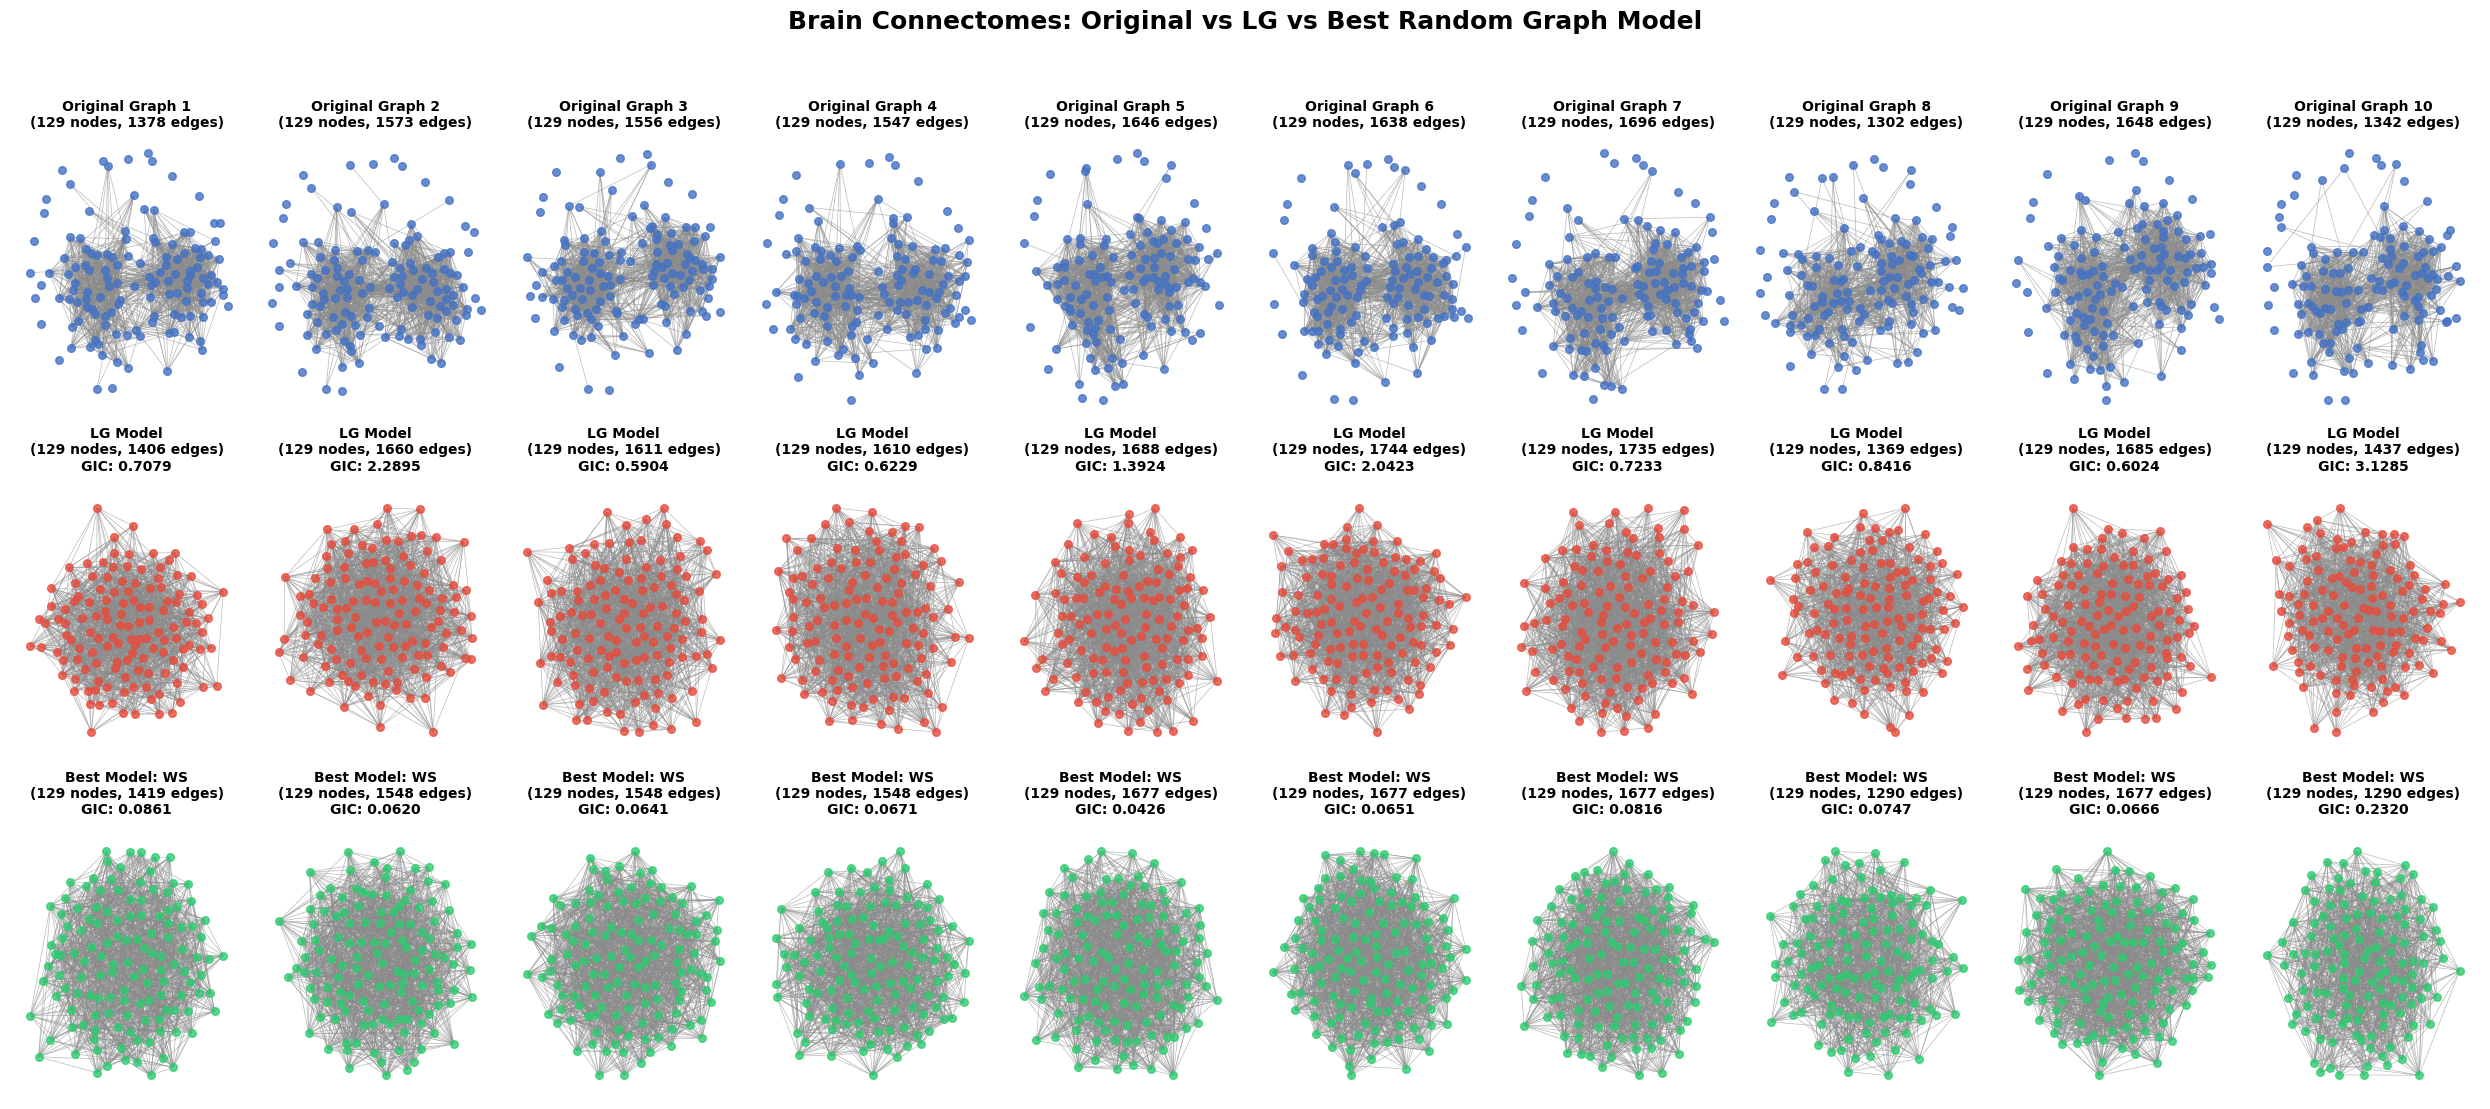

In [19]:
# Create the comparison visualization
fig_model_comparison = visualize_model_comparison(
    model_results, 
    figsize=(25, 12), 
    node_size=30, 
    font_size=8, 
    edge_width=0.5
)

In [20]:
import pickle
import os
os.makedirs(f'runs/fitting_results_braingraph_multiple_datasets', exist_ok=True)

# Save the complete results
with open(f'runs/fitting_results_braingraph_multiple_datasets/model_comparison_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

model_results['summary_df'].to_csv(f'runs/model_comparison_braingraph_multiple_datasets/model_comparison_results.csv', index=False)
df_graph_attr.to_csv(f'runs/model_comparison_braingraph_multiple_datasets/graph_attributes.csv', index=False)

# Save the figure
os.makedirs(f'../images/model_comparison_braingraph_multiple_datasets', exist_ok=True)
with open(f'../images/model_comparison_braingraph_multiple_datasets/model_comparison_graphs.pkl', 'wb') as f:
    pickle.dump(fig_model_comparison, f)



In [21]:
'finish'

'finish'